# Group Report

## Heart Disease
Today we will explore the heart disease dataset. We want to create a classifier model to predict whether a patient has heart disease by using age, cholesterol, resting blood pressure and maximum heart rate as variables. We chose these variables as our predictors because they are important risk factors according to a research article (Wilson, 1998) and (Hajar, 2017). However, we will implement forward selection to explore which of these variables would be optimal to predict our model.

The columns in this dataset are:
1. Age - (years)
2. Sex - (1 = male, 0 = female)
3. Chest Pain Type - (1 = typical angina)
                     (2 = atypical angina)
                     (3 = non-anginal pain)
                     (4 = asymptomatic)
4. Resting Blood Pressure - (mm Hg)
5. Cholesterol -(mg/dl)
6. Fasting Blood Sugar - (> 120 mg/dl)
                       - (1 = true; 0 = false)
7. Resting Electrocardiogram
8. Maximum heart rate
9. Exercised induced angina - (1 = yes; 0 = no)
10. ST depression induced by exercise relative to rest
11. Slope of peak exercise ST segment
12. Number of major vessels 
13. Blood disorder - 3 = normal
                     6 = fixed defect
                     7 = reversible defect
14. Heart disease status - (1 = yes, 0 = no)

In [1]:
# Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(digest)
library(cowplot)
library(infer)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
set.seed(20)

heart_data_1 <- read_csv("data/processed.cleveland (1).data", col_names = FALSE) |>
                mutate(X14 = as_factor(X14)) 
                
colnames(heart_data_1) <- c("age","sex","cp","trestbps","chol","fbs","restecg","thalach",
                                    "exang","oldpeak","slope","ca","thal","num") 

heart_data <- heart_data_1 |>
                mutate(num=recode(num, "0" = "0",
                                       "1" = "1",
                                       "2" = "1",
                                       "3" = "1",
                                       "4" = "1"))
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,1
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


                                                Fig1.0

We read the .csv file into R using read_csv. We didn't clean the data into tidy data, as the data is already tidy.

In [3]:
nrow(heart_data) 
heart_proportion <- heart_data |>
                    group_by(num) |>
                    summarise(n=n()) |>
                    mutate(proportion= n/303)
                    
heart_proportion

[1] 303

num,n,proportion
<fct>,<int>,<dbl>
0,164,0.5412541
1,139,0.4587459


        Fig1.1

This summary shows the proportion of patients having heart disease or not shows that our data is not biased as there is a good amount of both data. 

In [4]:
set.seed(20)
heart_split <- initial_split(heart_data, prop = 0.75, strata = num) 
heart_train <- training(heart_split)
heart_test <- testing(heart_split) 

We split our data into 75% of training data and 25% of testing data. This ensures that we have a large enough dataset for both the training and testing data.

# Method
First, we want to implement the forward selection to figure out which predictors out of age, cholesterol, maximum heart rate and resting blood pressure are the best for predicting our model. 

In [14]:
# forward selection
heart_subset <- heart_data |>
    select(num, age, chol, thalach, trestbps)

names <- colnames(heart_subset |> 
                  select(age, chol, thalach, trestbps))

example_formula <- paste("num", "~", paste(names, collapse="+"))

# create a tibble to store results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
heart_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# create 10 fold cross validation object
heart_vfold <- vfold_cv(heart_subset, v = 10, strata = num)

# store the number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names [[j]])
        model_string <- paste("num", "~", paste(preds_new, collapse="+"))
        
        #create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string),
                               data = heart_subset) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())
        
        # tune the KNN classifier with these predictors,
        # collect accuracy for the best K
        
        acc <- workflow() |>
        add_recipe(heart_recipe) |>
        add_model(heart_model) |>
        tune_grid(resamples = heart_vfold, grid = 10) |>
        collect_metrics() |>
        filter(.metric == "accuracy") |>
        summarize(mx = max(mean))
        acc <- acc$mx |> unlist()
        
        # add this result to the dataframe
        
        accs[[j]] <- acc
        models[[j]] <- model_string
        
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |>
        add_row(size = i,
               model_string = models[[jstar]],
               accuracy = accs[[jstar]])
    selected <- c(selected, names [[jstar]])
    names <- names[-jstar]
}
accuracies              

size,model_string,accuracy
<int>,<chr>,<dbl>
1,num ~ thalach,0.6665146
2,num ~ thalach+age,0.7157694
3,num ~ thalach+age+trestbps,0.6830664
4,num ~ thalach+age+trestbps+chol,0.6770671


                       Fig1.2

We found from the forward selection that the best predictors we should use are age and maximum heart rate as the accuracy for those predictors is the highest at 71.6%.

Next, we want to plot a graph of maximum heart rate against age to visualize their relationship.

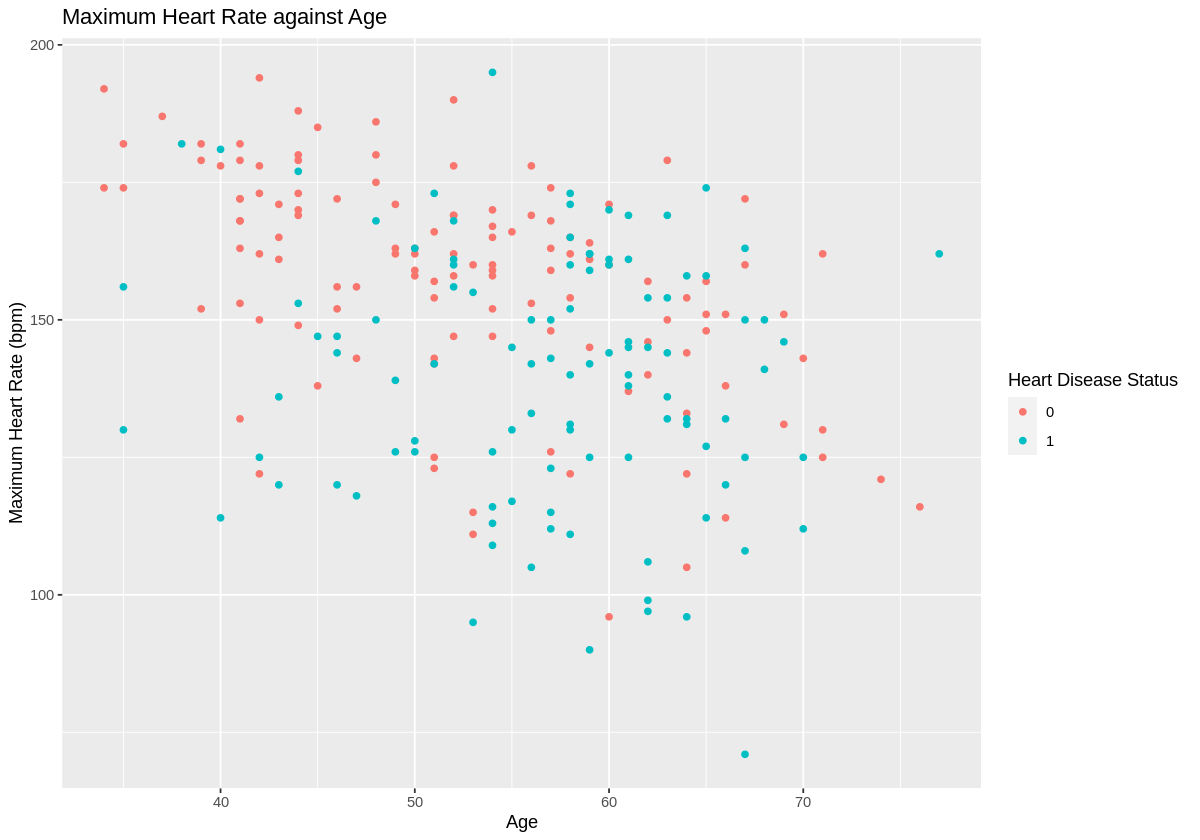

In [23]:
options(repr.plot.width = 10, repr.plot.height = 7)
heart_plot<- heart_train |>
            ggplot(aes (x = age, y = thalach, color = num)) +
            geom_point() +
            labs(x = "Age", y = "Maximum Heart Rate (bpm)", color = "Heart Disease Status") +
            ggtitle("Maximum Heart Rate against Age")
heart_plot

                                Fig1.3

Fig1.3 shows that with increasing age, there is a higher chance of having heart disease. This is shown as more blue data points with increasing age. However, for maximum heart rate, the plot is scattered, hence we are unable to say much. However, because the forward selection informed us that these two variables would best predict our model, we would still use these two variables.

Next, we created a recipe for our model to include age, and maximum heart rate as the variables we want to use to predict whether our patient has heart disease. We assigned this object 'heart_recipe'. Next, we want to perform cross-validation to decide the most accurate K value we should use, hence we created a model with tune as neighbors. This model is assigned 'heart_model'.

In [24]:
set.seed(20)

heart_recipe <- recipe(num ~ age + thalach, data = heart_train) |>
                step_center(all_predictors()) |>
                step_scale(all_predictors())

heart_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

We separated the data into 10 subsets of data to run the cross-validation and assigned it 'heart_vfold'. We chose 10-fold cross-validation because 10 is sufficient enough for a low standard error, hence improving the accuracy of our predicting model. Next, we want to run the cross-validation with different numbers of K-nearest neighbours, hence we assigned that object 'gridvals'. After that, we added the recipe and model into a workflow and assigned it 'heart_results' to assess the accuracy of our predicting model with 1-30 values of K. 

In [27]:
set.seed(20)

heart_vfold <- vfold_cv(heart_train, v = 10, strata = num)

gridvals <- tibble(neighbors = seq(from = 1, to = 30))

heart_results <- workflow() |>
              add_recipe(heart_recipe) |>
              add_model(heart_model) |>
              tune_grid(resamples = heart_vfold, grid = gridvals) |>
              collect_metrics() |>
              filter(.metric == "accuracy")
heart_results


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5607049,10,0.03906514,Preprocessor1_Model01
2,accuracy,binary,0.5607049,10,0.03906514,Preprocessor1_Model02
3,accuracy,binary,0.5900198,10,0.03290127,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,accuracy,binary,0.6824769,10,0.03178630,Preprocessor1_Model28
29,accuracy,binary,0.6695982,10,0.03382308,Preprocessor1_Model29
30,accuracy,binary,0.6741436,10,0.03223762,Preprocessor1_Model30


                                Fig1.4

The Fig1.4 shows the accuracy of using 1 to 30 K-nearest neighbours. However, to find the optimal K-nearest neighbor, we want to plot a graph of K-nearest against accuracy.

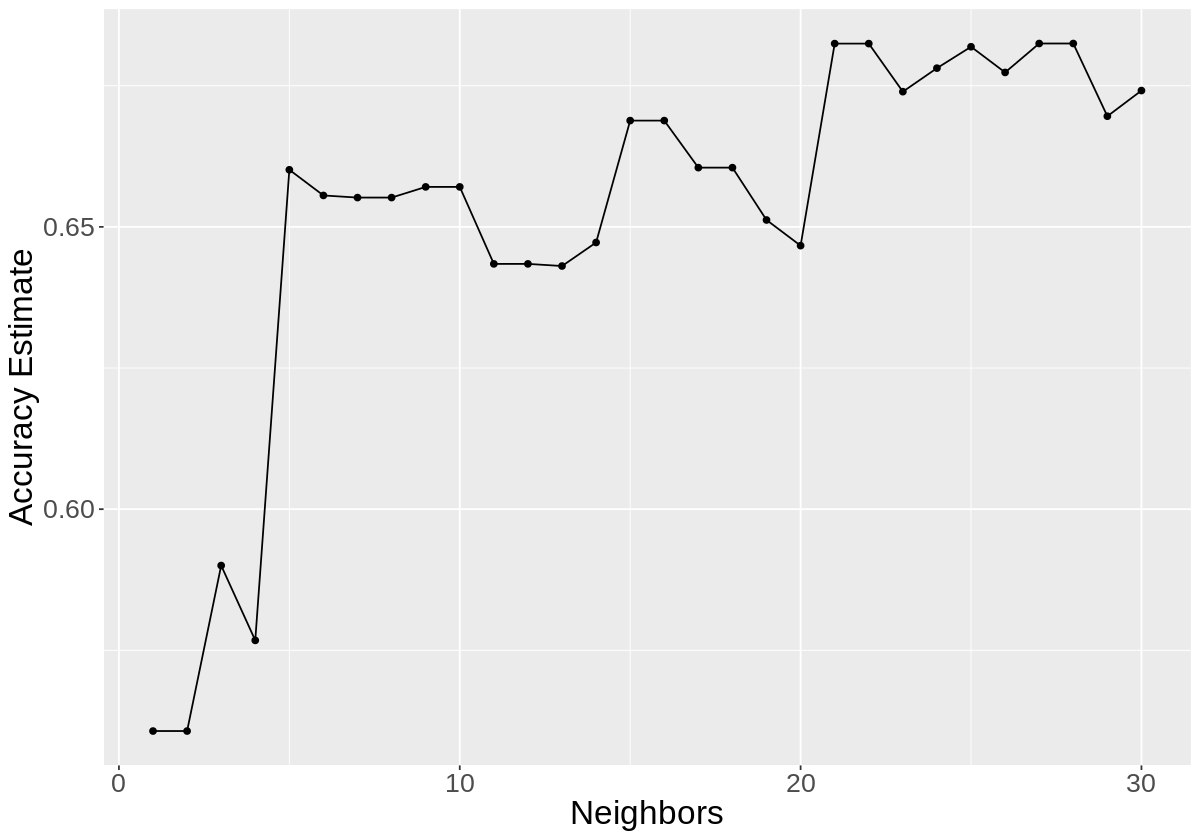

In [28]:
heart_k_plot <- heart_results |> 
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "Neighbors", y = "Accuracy Estimate") +
                theme(text = element_text(size = 20))
heart_k_plot

                                     Fig1.5

Our graph shows that using either K= 21 or 22 would provide us the optimal accuracy, hence we will build a model using K=22.

In [29]:
set.seed(20)

best_heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 22) |>
                set_engine("kknn") |>
                set_mode("classification")

best_heart_fit <- workflow() |>
                add_recipe(heart_recipe) |>
                add_model(best_heart_spec) |>
                fit(data = heart_train)

best_heart_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(22,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3348018
Best kernel: rectangular
Best k: 22

Finally, we want to use our model to predict on the test dataset to figure out whether a patient has heart disease, which we assigned our object 'heart_predictions'. Next, we find the accuracy our model has in predicting and assigned our object 'heart_metrics'.

In [33]:
set.seed(20)

heart_predictions <- predict(best_heart_fit, heart_test) |>
                    bind_cols(heart_test)

heart_metrics <- heart_predictions |>
                metrics(truth = num, estimate = .pred_class)
heart_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7894737
kap,binary,0.5763066


Fig1.6

Fig1.6 shows that the accuracy of our model is 78.9%. 

In [34]:
heart_conf_mat <- heart_predictions |>
                conf_mat(truth = num, estimate = .pred_class)
heart_conf_mat

          Truth
Prediction  0  1
         0 33  8
         1  8 27

        Fig1.7

Fig1.7 is the confusion matrix, which shows how many numbers of predictions were right and wrong in predicting heart disease.

Next, we want to visualise the proportions of right and wrong predictions, hence we plotted a pie chart.

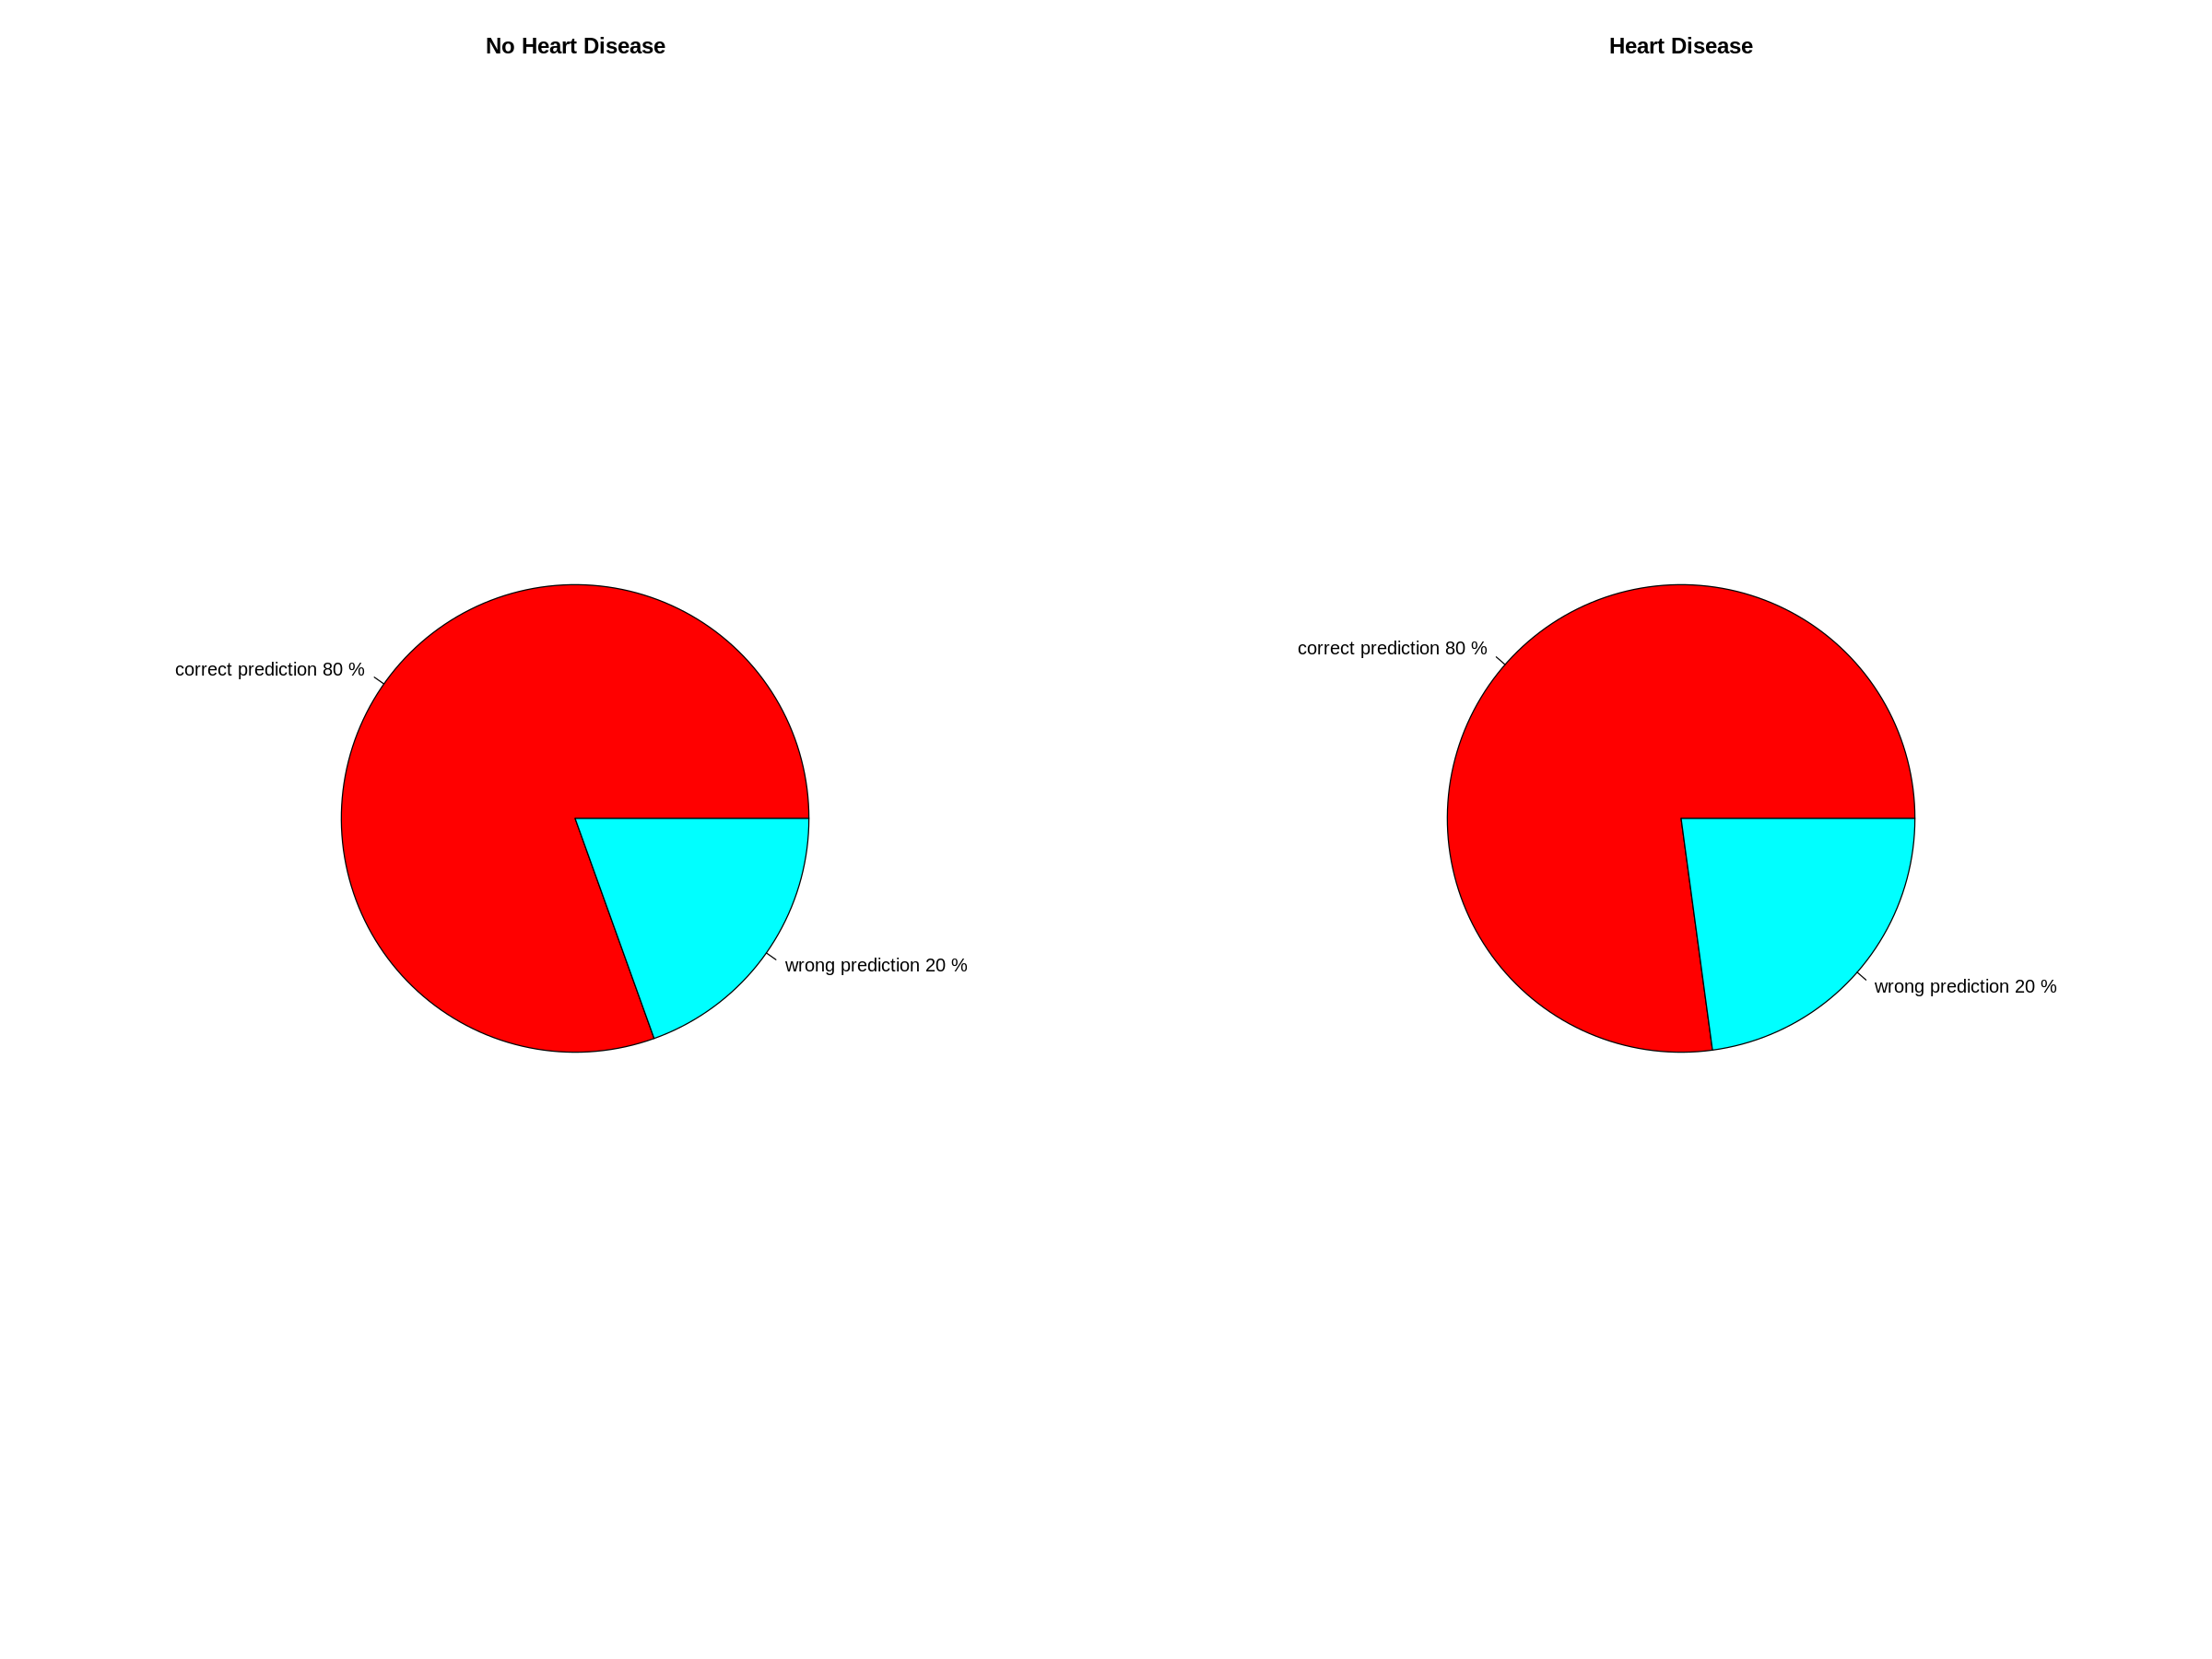

In [47]:
options(repr.plot.width = 20, repr.plot.height = 15)
par(mfrow = c(1, 2))
slices <- c(33, 8)
labels <- c("correct prediction", "wrong prediction")
pct <- round(slices/sum(slices)*100)
labels <- paste(labels, pct)
labels <- paste(labels,"%", sep=" ")
pie(slices,labels = labels, col=rainbow(length(labels)),
   main = "No Heart Disease")

slices_1 <- c(27, 8)
labels_1 <- c("correct prediction", "wrong prediction")
pct_1 <- round(slices/sum(slices)*100)
labels_1 <- paste(labels_1, pct)
labels_1 <- paste(labels_1,"%", sep=" ")
pie(slices_1,labels = labels_1, col=rainbow(length(labels_1)),
   main = "Heart Disease")

                                                        Fig1.8 

These pie charts show how well our model does in predicting heart disease. We can see that the correction prediction in both pie charts is 80%, and the wrong prediction in both pie charts is 20%. 

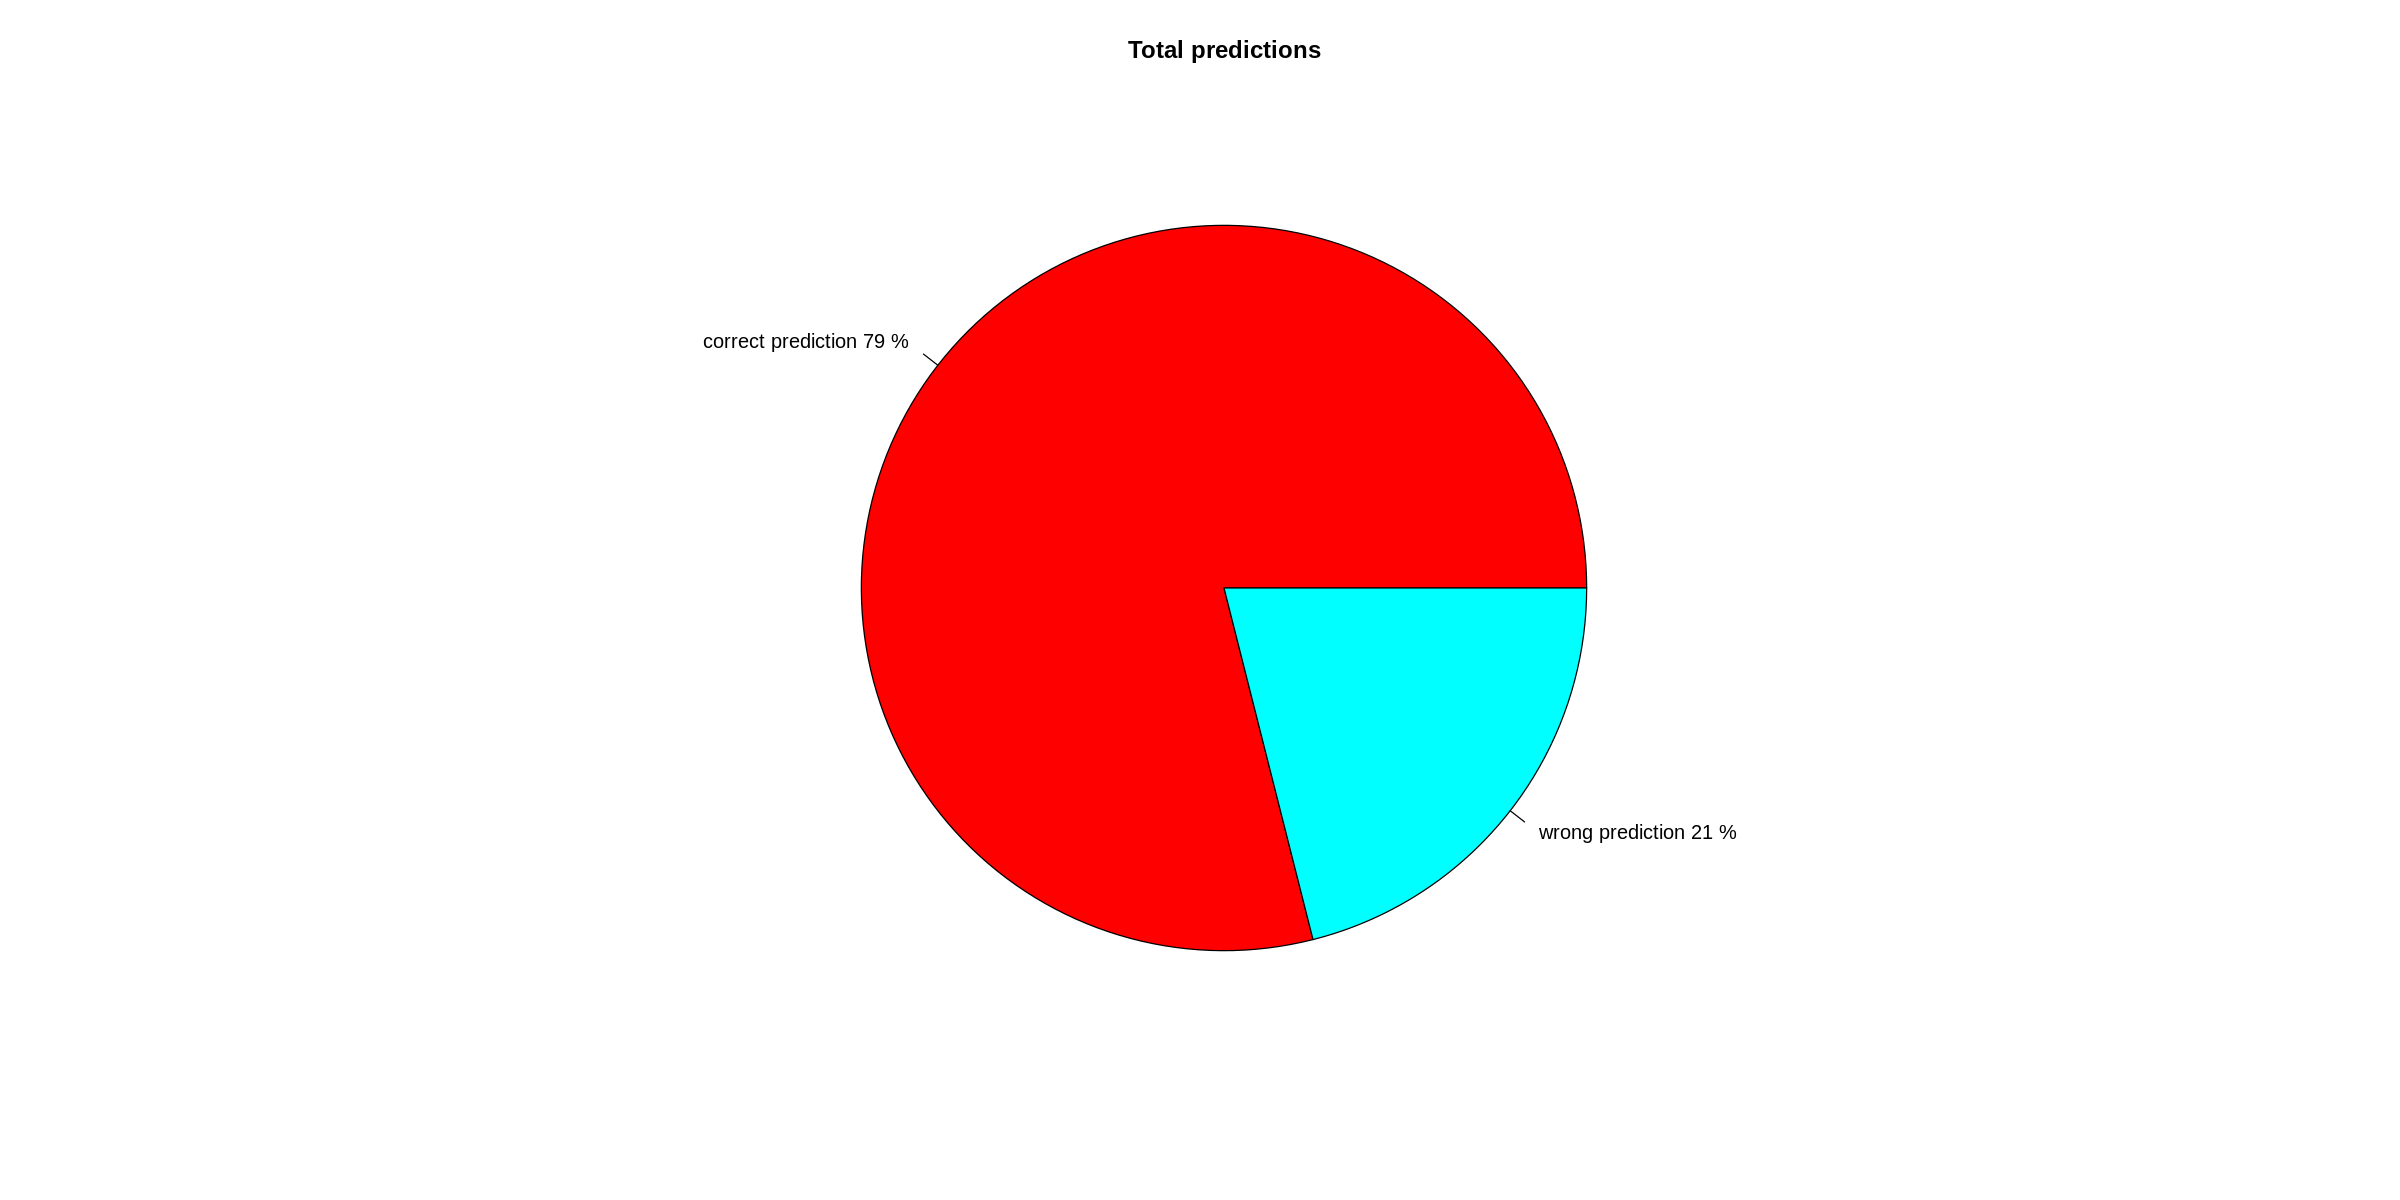

In [49]:
options(repr.plot.width = 20, repr.plot.height = 10)
slices <- c(60, 16)
labels <- c("correct prediction", "wrong prediction")
pct <- round(slices/sum(slices)*100)
labels <- paste(labels, pct)
labels <- paste(labels,"%", sep=" ")
pie(slices,labels = labels, col=rainbow(length(labels)), main = "Total predictions")

                                                            Fig1.9

This pie chart shows that our model predicts presence and absence of heart disease correctly 79% of the time.

# Discussion
From Fig1.6, we found that the accuracy of our model is 78.9%, and a visualisation of this is shown in Fig1.9. This is fairly low and we believe that the cause of this is due to the external factors that would affect whether a patient has heart disease. For example, if someone had another disease such as diabetes or obesity, it would increase their chances of having heart disease, and this presence of another disease is not included in our model. Moreover, whether a patient smokes or not would also affect the presence of heart disease and this factor is not included our model. Hence, this accuracy of our model was what we predicted as using age and maximum heart rate as our only predictor variables is not sufficient enough to predict whether someone has heart disease. 

Now that we know other external factors such as diabetes, obesity, and presence of smoking can affect whether a person has heart disease, we can include data relevant to those factors and use those variables as our predictors to further increase the accuracy of our model. Once, the accuracy of our model is high enough, we can use our model to know whether the patient has heart disease earlier on. This allows the treatment for heart disease to be conducted before the condition can deteriorate further. A question that brought up is how we can use our model for other purposes. Instead of our variables being independent of each other, we can use our model to figure out the relationship between our variables.

Citations:
1. Detrano, R., Janosi, A., Steinbrunn, W., & Pfisterer, M. (1988). Heart Disease Data Set.      https://archive.ics.uci.edu/ml/datasets/Heart+Disease

2. Wilson, P. W. F., D'Agostino, R. B., Levy, D., Belanjer, A. M., Silbershatz, H., & Kannel, W.B. (1998). Prediction of Coronary Heart Disease Using Risk Categories. Circulation, 97(18), 1837-1847. https://doi.org/10.1161/01.CIR.97.18.1837

3. Hajar, R. (2017). Risk factors of Coronary Heart Disease: historical perspectives. Heart Views, 18(3), 109-114. https://doi.org/10.4103/HEARTVIEWS.HEARTVIEWS_106_17 